# Outlier detection using PCA

In [56]:
import sys,os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.patches as mpatches

In [2]:
path_images = 'D:\\Users\\S37283\\Documents\\Outlier detection'

In [3]:
def read_images(path, sz=None,sz0=168,sz1=192): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given) and check that it's the good size
                    if ((im.size[0] == sz0) & (im.size[1]==sz1)):
                        if (sz is not None):
                            im = im.resize(sz, Image.NEAREST)     
                        X.append(np.asarray(im, dtype=np.uint8)) 
                        y.append(c)
                except IOError:
                    pass
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
            
    print("Images chargees !")
    return [X,y]

In [4]:
X_original, y_original = read_images(path_images, sz=None)
X_small, y_small = read_images(path_images, sz=(12,10))

Images chargees !
Images chargees !


In [5]:
print("Nombre d'éléments chargés ",len(X_original))

Nombre d'éléments chargés  2560


In [6]:
def noise_image(image_input, per=0.5):
    '''
    Ajoute du bruit à une image : met un pourcentage de pixel à 0.
    @params:
        per : pourcentage de pixels à corrompre
    '''
    sz0 = image_input.shape[0]
    sz1 = image_input.shape[1]
    
    # Création du masque
    nb_pix_to_noise = int(np.floor(per*sz0*sz1))
    
    mask = np.ones((sz0*sz1,1))
    ids = np.random.permutation(sz0*sz1)[0:nb_pix_to_noise]
    mask[ids] = 0
    mask = np.reshape(mask,(sz0,sz1))
    
    # Matrice de pixels aléatoires (intensité entre 0 et 255)
    #rand_pix = np.random.randint(0,256,size=(sz0,sz1))
    rand_pix =np.zeros((sz0,sz1))
    
    # On retourne la matrice initiale où l'on a changé les pixels indiqués par des pixels noirs
    return np.multiply(mask,image_input) + np.multiply(1-mask,rand_pix)

In [7]:
def black_frame(array_orig, x0, x1, y0, y1):
    '''
    Ajoute un bandeau noir dont les coins sont de coordonnées (x0,y0),(x1,y1),(x0,y1) et (x1,y0)
    '''
    array_tmp = np.ones_like(array_orig)
    
    if ((x0 > array_tmp.shape[1]) | (x1 > array_tmp.shape[1]) | (y0 > array_tmp.shape[0]) | (y1 > array_tmp.shape[0])):
        print("Error : coordonnees du bandeau trop grandes pour l'image")
    
    for i in range(array_tmp.shape[1]):
        for j in range(array_tmp.shape[0]):
            if ((i >= min(x0,x1)) & (i <= max(x0,x1)) & (j >= min(y0,y1)) & (j <= max(y0,y1))):
                array_tmp[j][i] = 0
    
    return array_tmp*array_orig

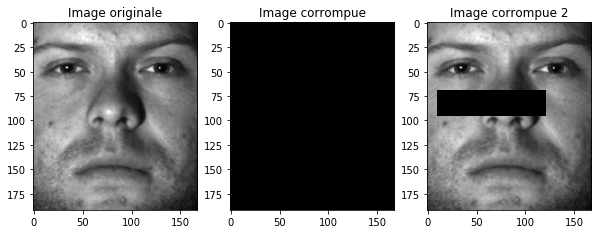

In [139]:
tmp = noise_image(X_original[12],1)
tmp2 = black_frame(X_original[12],10,120,95,69)
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[12], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(tmp,cmap='gray')
plt.title('Image corrompue')
plt.subplot(1,3,3)
plt.imshow(tmp2,cmap='gray')
plt.title('Image corrompue 2')
plt.show()

# Outlier detection on all dataset using PCA

On va rajouter des outliers de type black frame dans le dataset original et voir si on peut les détecter

In [142]:
sz0 = X_original[12].shape[0]
sz1 = X_original[12].shape[1]

In [113]:
stackedX=np.hstack((X_original[0].reshape((sz0*sz1,1)),X_original[1].reshape((sz0*sz1,1))))
for i in range(2,len(X_original)):
    stackedX=np.hstack((stackedX,X_original[i].reshape((sz0*sz1,1))))
stackedX=np.transpose(stackedX)

In [114]:
stackedX.shape

(2560, 32256)

In [143]:
indexes=['img'+str(i) for i in range(stackedX.shape[0])]

In [144]:
df=pd.DataFrame(data=stackedX,index=indexes)

In [145]:
df['state']='normal'

In [146]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32247,32248,32249,32250,32251,32252,32253,32254,32255,state
img0,80,80,84,90,92,97,97,95,98,100,...,24,24,21,22,17,12,12,12,11,normal
img1,94,94,96,102,109,115,110,109,114,116,...,15,15,10,9,7,6,6,7,8,normal
img2,59,66,77,86,92,99,103,110,112,119,...,8,7,6,6,5,3,5,7,7,normal
img3,16,18,22,23,28,31,28,26,25,24,...,5,5,6,5,5,3,7,6,5,normal
img4,69,71,77,79,79,77,77,81,83,87,...,41,36,37,34,22,24,23,23,26,normal


In [17]:
noisyimages=[]
noisyimages.append(black_frame(X_original[1],10,152,39,69))
noisyimages.append(black_frame(X_original[5],10,152,19,49))
noisyimages.append(black_frame(X_original[7],10,152,59,89))
noisyimages.append(black_frame(X_original[12],10,152,79,109))
noisyimages.append(black_frame(X_original[8],10,152,99,129))
noisyimages.append(black_frame(X_original[15],10,152,19,12))
noisyimages.append(black_frame(X_original[100],10,152,99,69))
noisyimages.append(black_frame(X_original[78],50,152,39,69))
noisyimages.append(black_frame(X_original[59],10,132,39,69))
noisyimages.append(black_frame(X_original[300],20,152,39,69))
noisyimages.append(black_frame(X_original[120],10,102,79,69))
noisyimages.append(black_frame(X_original[18],10,152,39,69))
noisyimages.append(black_frame(X_original[256],10,152,39,69))

In [140]:
noisyimages=[]
noise=1
noisyimages.append(noise_image(X_original[1],noise))
noisyimages.append(noise_image(X_original[5],noise))
noisyimages.append(noise_image(X_original[7],noise))
noisyimages.append(noise_image(X_original[12],noise))
noisyimages.append(noise_image(X_original[8],noise))
noisyimages.append(noise_image(X_original[15],noise))
noisyimages.append(noise_image(X_original[100],noise))
noisyimages.append(noise_image(X_original[78],noise))
noisyimages.append(noise_image(X_original[59],noise))
noisyimages.append(noise_image(X_original[300],noise))
noisyimages.append(noise_image(X_original[120],noise))
noisyimages.append(noise_image(X_original[18],noise))
noisyimages.append(noise_image(X_original[256],noise))

In [147]:
stackednoisyimages=np.hstack((noisyimages[0].reshape((sz0*sz1,1)),noisyimages[1].reshape((sz0*sz1,1))))
for i in range(2,len(noisyimages)):
    stackednoisyimages=np.hstack((stackednoisyimages,noisyimages[i].reshape((sz0*sz1,1))))
stackednoisyimages=np.transpose(stackednoisyimages)

In [148]:
outliers=[]
for img in stackednoisyimages:
    outliers.append(list(img)+['outlier'])

In [149]:
dfoutlier=pd.DataFrame(outliers,columns=df.columns)

In [150]:
df=df.append(dfoutlier)

In [151]:
pca=PCA(n_components=20,svd_solver='arpack')

In [152]:
pca.fit(df.drop('state', axis=1))

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

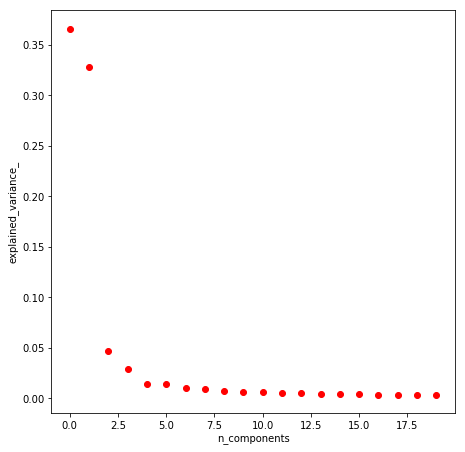

In [153]:
plt.figure(1, figsize=(8, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_,'ro', linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

### Projection sur les deux pemières composantes

In [154]:
pca=PCA(n_components=2,svd_solver='arpack')
pca.fit(df.drop('state', axis=1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

In [155]:
z=pca.transform(df.drop('state', axis=1))
xproj=pca.inverse_transform(z)

In [156]:
xproj.shape

(2573, 32256)

In [157]:
z.shape

(2573, 2)

In [158]:
#first we need to map colors on labels
dfcolor = pd.DataFrame([['outlier','red'],['normal','darkblue']],columns=['state','Color'])
mergeddf = pd.merge(df,dfcolor)

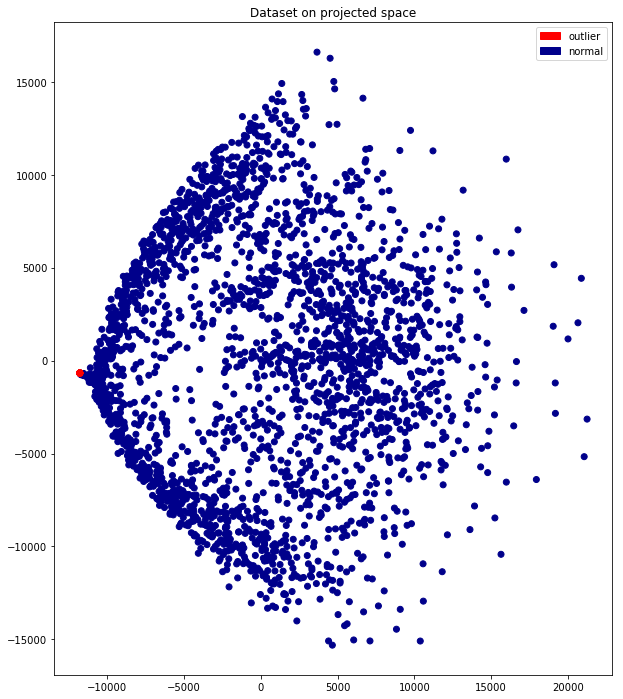

In [168]:
red_patch = mpatches.Patch(color='red', label='outlier')
blue_patch = mpatches.Patch(color='darkblue', label='normal')
plt.figure(figsize=(10,12))
plt.clf()

plt.scatter(z[:,0],z[:,1],color=mergeddf['Color'])
plt.legend(handles=[red_patch,blue_patch])
plt.title('Dataset on projected space')
plt.show()

In [164]:
pca.components_[0]

array([ 0.00058867,  0.00060141,  0.00075905, ...,  0.00102754,
        0.0008835 ,  0.00079203])

### Isolation forest 

In [133]:
from sklearn.ensemble import IsolationForest

In [134]:
X_train=df.drop('state', axis=1)
#X_test=df[df['state']=='normal'].drop('state', axis=1).sample(frac=0.1)
#X_outliers=df[df['state']=='outlier'].drop('state', axis=1)

In [135]:
clf = IsolationForest(max_samples=100)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
#y_pred_test = clf.predict(X_test)
#y_pred_outliers = clf.predict(X_outliers)

### Visualisation

In [136]:
df['predoutlier']=['predicted_inlier' if y_pred_train[i]==1 else 'predicted_outlier' for i in range(len(y_pred_train))]

In [137]:
#first we need to map colors on labels
dfcolor = pd.DataFrame([['outlier','red'],['normal','darkblue']],columns=['state','Color'])
dfcolor2 = pd.DataFrame([['predicted_inlier','blue'],['predicted_outlier','pink']],columns=['predoutlier','Color'])
mergeddf = pd.merge(df,dfcolor)
mergeddf2 = pd.merge(df,dfcolor2)

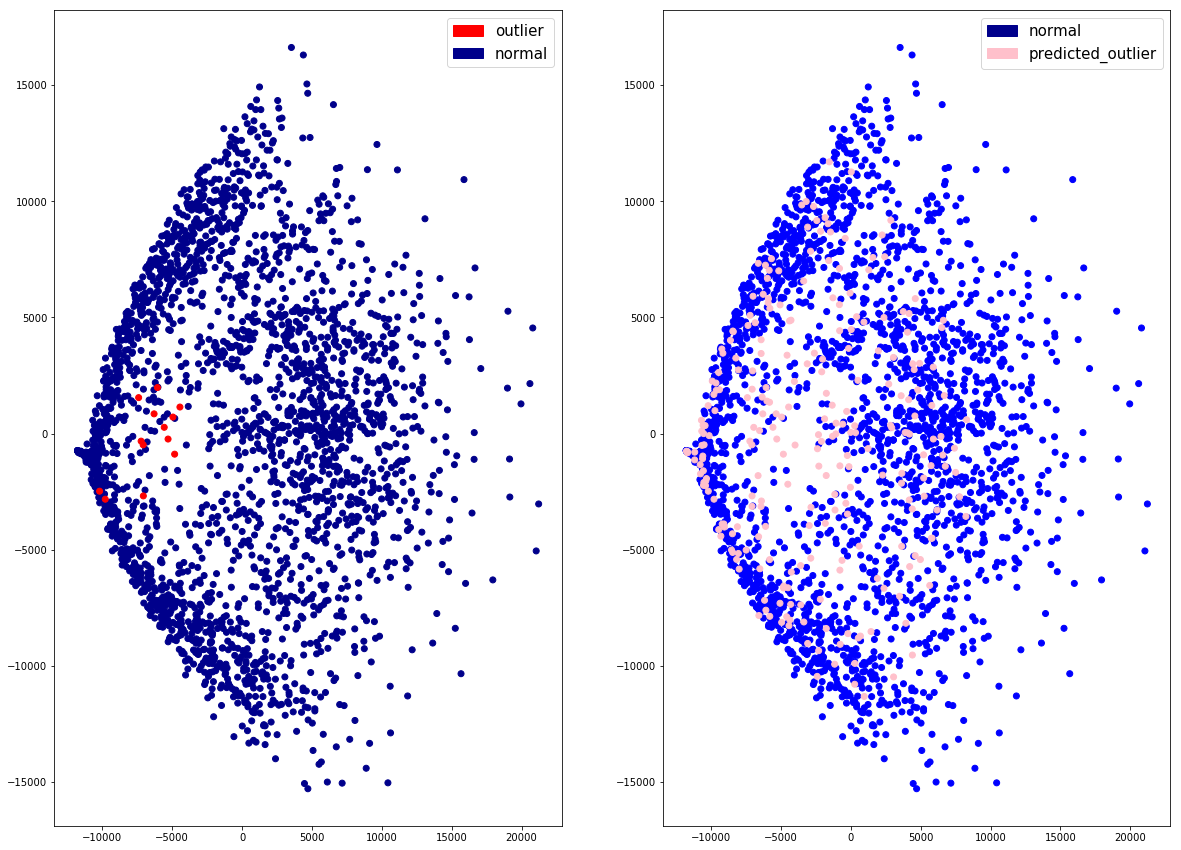

In [138]:
red_patch = mpatches.Patch(color='red', label='outlier')
blue_patch = mpatches.Patch(color='darkblue', label='normal')
pink_patch = mpatches.Patch(color='pink', label='predicted_outlier')
darkblue_patch = mpatches.Patch(color='blue', label='predicted_inlier')
plt.figure(figsize=(20,15))
plt.clf()
plt.title('Dataset on projected space')
plt.subplot(1,2,1)
plt.scatter(z[:,0],z[:,1],color=mergeddf['Color'])
plt.legend(handles=[red_patch,blue_patch],fontsize=15)
plt.subplot(1,2,2)
plt.scatter(z[:,0],z[:,1],color=mergeddf2['Color'])
plt.legend(handles=[blue_patch,pink_patch],fontsize=15)
plt.show()

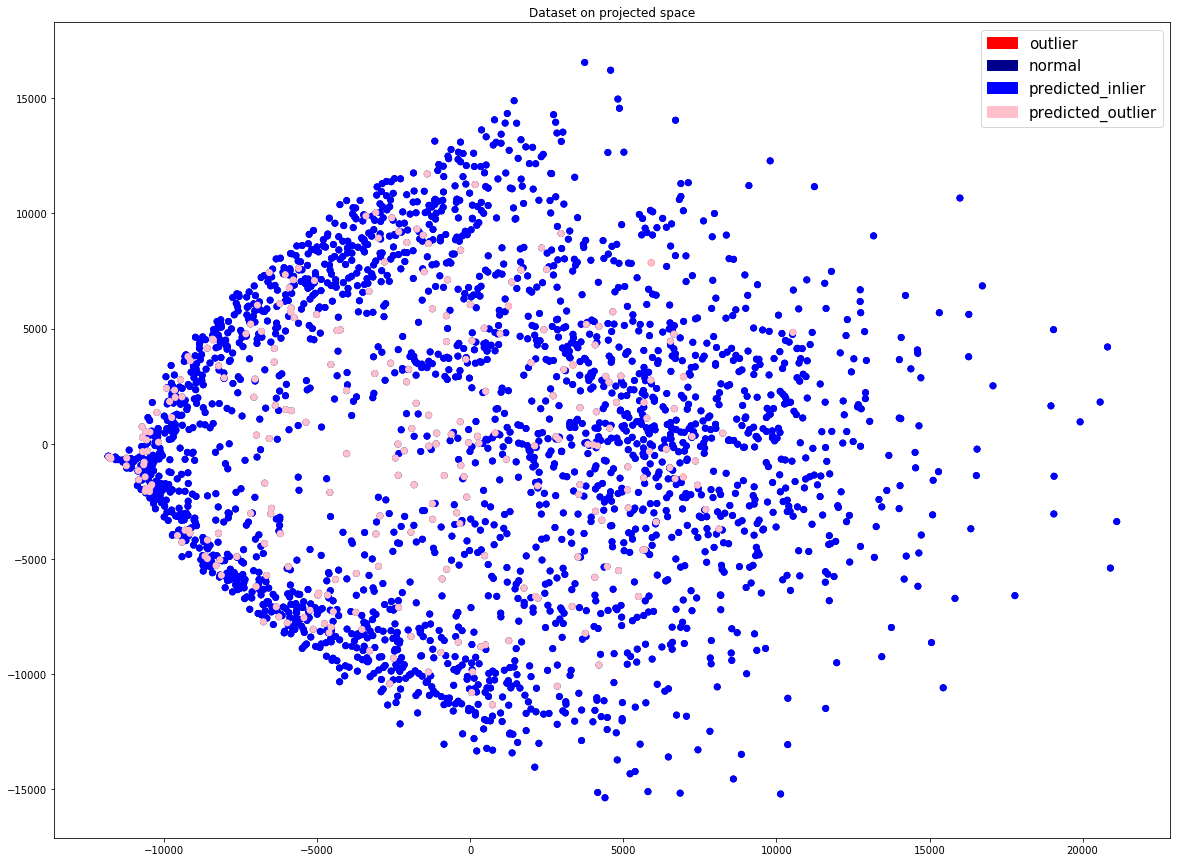

In [111]:
red_patch = mpatches.Patch(color='red', label='outlier')
blue_patch = mpatches.Patch(color='darkblue', label='normal')
pink_patch = mpatches.Patch(color='pink', label='predicted_outlier')
darkblue_patch = mpatches.Patch(color='blue', label='predicted_inlier')
fig =plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111)
plt.title('Dataset on projected space')
ax1.scatter(z[:,0],z[:,1],color=mergeddf['Color'])
ax1.scatter(z[:,0],z[:,1],color=mergeddf2['Color'])
plt.legend(handles=[red_patch,blue_patch,darkblue_patch,pink_patch],fontsize=15)
plt.show()

In [105]:
plt.plot(type='blue')

[]

# PCA analysis for outlier detection

In [234]:
def random_img(sz0,sz1):
    '''
    Créée une image random de taille sz0*sz1
    '''
    return (256)*np.random.random_sample((sz0, sz1))

In [243]:
def add_noise_in_data(amount,noisedown,X_original):
    sz0 = X_original[0].shape[0]
    sz1 = X_original[0].shape[1]
    noisyimages=[]
    N=len(X_original)
    nbimgs=int(amount*len(X_original))
    for i in range(nbimgs):
        noise=(1-noisedown)*np.random.random_sample()+noisedown
        noisyimages.append(noise_image(X_original[np.random.randint(low=10,high=N,size=1)[0]],noise))

    return noisyimages

In [244]:
def add_random_noise_in_data(amount,X_original):
    sz0 = X_original[0].shape[0]
    sz1 = X_original[0].shape[1]
    noisyimages=[]
    N=len(X_original)
    nbimgs=int(amount*len(X_original))
    for i in range(nbimgs):
        noisyimages.append(random_img(sz0,sz1))
        
    return noisyimages

In [245]:
def create_df(X_original,noisyimages):
    
    sz0 = X_original[0].shape[0]
    sz1 = X_original[0].shape[1]
    stackedX=np.hstack((X_original[0].reshape((sz0*sz1,1)),X_original[1].reshape((sz0*sz1,1))))
    stackednoisyimages=np.hstack((noisyimages[0].reshape((sz0*sz1,1)),noisyimages[1].reshape((sz0*sz1,1))))
    for i in range(2,len(X_original)):
        stackedX=np.hstack((stackedX,X_original[i].reshape((sz0*sz1,1))))
    stackedX=np.transpose(stackedX)
    indexes=['img'+str(i) for i in range(stackedX.shape[0])]
    df=pd.DataFrame(data=stackedX,index=indexes)
    df['state']='normal'
    
    for i in range(2,len(noisyimages)):
        stackednoisyimages=np.hstack((stackednoisyimages,noisyimages[i].reshape((sz0*sz1,1))))
    stackednoisyimages=np.transpose(stackednoisyimages)
    outliers=[]
    for img in stackednoisyimages:
        outliers.append(list(img)+['outlier'])
    dfoutlier=pd.DataFrame(outliers,columns=df.columns)
    
    df=df.append(dfoutlier)
    
    return df

In [252]:
noisyimages=add_random_noise_in_data(0.5,X_original)

In [256]:
noisyimages=add_noise_in_data(0.5,0.5,X_original)

In [257]:
df=create_df(X_original,noisyimages)

In [258]:
pca=PCA(n_components=2,svd_solver='arpack')
pca.fit(df.drop('state', axis=1))
z=pca.transform(df.drop('state', axis=1))

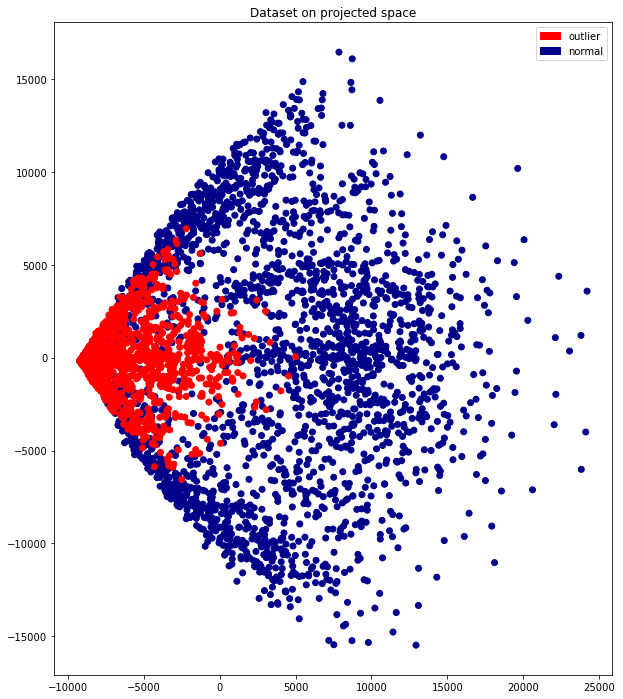

In [259]:
#first we need to map colors on labels
dfcolor = pd.DataFrame([['outlier','red'],['normal','darkblue']],columns=['state','Color'])
mergeddf = pd.merge(df,dfcolor)
red_patch = mpatches.Patch(color='red', label='outlier')
blue_patch = mpatches.Patch(color='darkblue', label='normal')
plt.figure(figsize=(10,12))
plt.clf()

plt.scatter(z[:,0],z[:,1],color=mergeddf['Color'])
plt.legend(handles=[red_patch,blue_patch])
plt.title('Dataset on projected space')
plt.show()